# Synthetic control with `pymc` models

In [1]:
import arviz as az
import pandas as pd
import pathlib

In [2]:
# %config InlineBackend.figure_format = 'svg'
az.style.use("arviz-darkgrid")

In [3]:
%load_ext autoreload
%autoreload 2

## Load data

In [4]:
sc_data_path = (
    pathlib.Path.cwd().parents[1] / "causalpy" / "data" / "synthetic_control.csv"
)
df = pd.read_csv(sc_data_path)
treatment_time = 70

## Run the analysis

In [5]:
from causalpy.pymc_experiments import SyntheticControl
from causalpy.pymc_models import WeightedSumFitter

# Note, we do not want an intercept in this model
result = SyntheticControl(
    df,
    treatment_time,
    formula="actual ~ 0 + a + b + c + d + e + f + g",
    prediction_model=WeightedSumFitter(),
)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [beta, sigma]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 8 seconds.
Sampling: [beta, sigma, y_hat]
Sampling: [y_hat]


Sampling: [y_hat]


Sampling: [y_hat]


Sampling: [y_hat]


/Users/benjamv/mambaforge/envs/CausalPy/lib/python3.10/site-packages/arviz/plots/hdiplot.py:156: FutureWarning: hdi currently interprets 2d data as (draw, shape) but this will change in a future release to (chain, draw) for coherence with other functions
  hdi_data = hdi(y, hdi_prob=hdi_prob, circular=circular, multimodal=False, **hdi_kwargs)
/Users/benjamv/mambaforge/envs/CausalPy/lib/python3.10/site-packages/arviz/plots/hdiplot.py:156: FutureWarning: hdi currently interprets 2d data as (draw, shape) but this will change in a future release to (chain, draw) for coherence with other functions
  hdi_data = hdi(y, hdi_prob=hdi_prob, circular=circular, multimodal=False, **hdi_kwargs)
/Users/benjamv/mambaforge/envs/CausalPy/lib/python3.10/site-packages/arviz/plots/hdiplot.py:156: FutureWarning: hdi currently interprets 2d data as (draw, shape) but this will change in a future release to (chain, draw) for coherence with other functions
  hdi_data = hdi(y, hdi_prob=hdi_prob, circular=circula

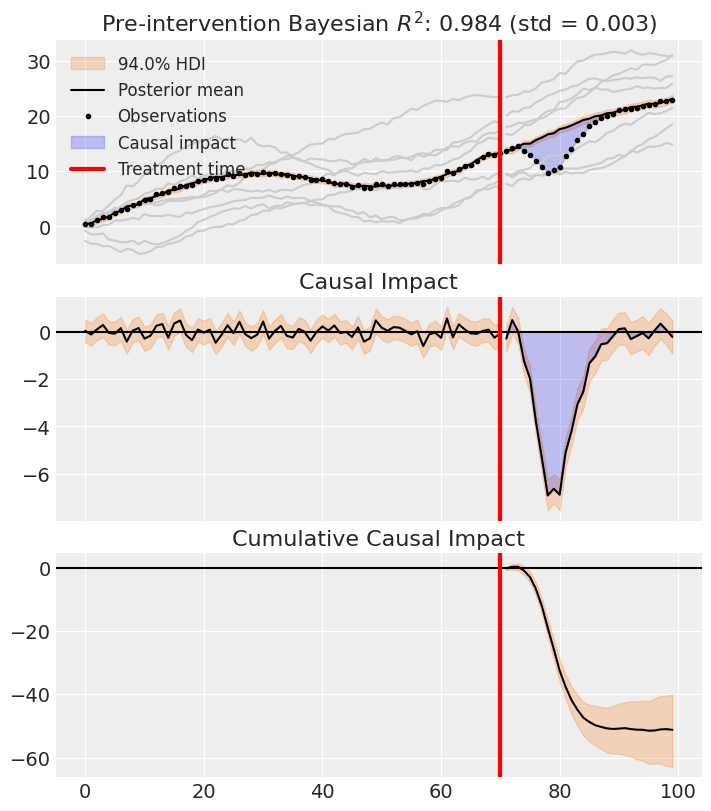

In [6]:
fig, ax = result.plot(plot_predictors=True)

In [7]:
result.summary()

===============================Synthetic Control================================
Formula: actual ~ 0 + a + b + c + d + e + f + g
Model coefficients:
  a                             0.34, 94% HDI [0.30, 0.38]
  b                             0.05, 94% HDI [0.01, 0.09]
  c                             0.30, 94% HDI [0.26, 0.35]
  d                             0.05, 94% HDI [0.02, 0.10]
  e                             0.03, 94% HDI [0.00, 0.06]
  f                             0.19, 94% HDI [0.11, 0.26]
  g                             0.04, 94% HDI [0.00, 0.09]
  sigma                         0.26, 94% HDI [0.22, 0.30]


As well as the model coefficients, we might be interested in the avarage causal impact and average cumulative causal impact.

<div class="alert alert-info">

Note

Better output for the summary statistics are in progress!

</div>

In [8]:
az.summary(result.post_impact.mean("obs_ind"))

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
x,-1.767,0.218,-2.172,-1.383,0.027,0.02,68.0,445.0,1.04


<div class="alert alert-warning">

Warning

Care must be taken with the mean impact statistic. It only makes sense to use this statistic if it looks like the intervention had a lasting (and roughly constant) effect on the outcome variable. If the effect is transient, then clearly there will be a lot of post-intervention period where the impact of the intervention has 'worn off'. If so, then it will be hard to interpret the mean impacts real meaning.

</div>

We can also ask for the summary statistics of the _cumulative_ causal impact.

In [9]:
# get index of the final time point
index = result.post_impact_cumulative.obs_ind.max()
# grab the posterior distribution of the cumulative impact at this final time point
last_cumulative_estimate = result.post_impact_cumulative.sel({"obs_ind": index})
# get summary stats
az.summary(last_cumulative_estimate)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
x,-51.253,6.316,-62.984,-40.098,0.785,0.585,68.0,445.0,1.04
